# 8.2 User-Equipment side: Blind Decoding Of Physical Downlink Control Channel on Plutto-SDR

The tutorial demonstrates the downlink synchronization using synchronization signal block (SSB) and PDCCH blind decoding in 5G networks.
The SSB consists of 4 elements:

- Primary Synchronization Signal (PSS)
- Secondary Synchronization Signal (SSS)
- Physical Broadacast Channel (PBCH) Payload: 432 symbols
- Demodulation Reference Signal (DMRS) for PBCH

The PDCCH consists of 2 elements:
- Define the PDCCH coreset and search space set parameters.
    - Aggregation level
    - frequency domain resources
    - duration
    - monitoring symbols with in a slot
    - search space set type
    - CCE to REG mapping
    - REG bundle size
    - Interleaver size
    - shift index 
    
- Decode the PDCCH candidates blindly based on the chosen parameters.

The tutorial performs following procedures:

- [Import Libraries](#8.2-Import-Libraries)
    - [Import Python Libraries](#8.2-Import-Python-and-SDR-Libraries)
    - [Import 5G Toolkit Libraries](#8.2-Import-5G-Toolkit-Libraries)
- [Emulation Configurations](#8.2-Emulation-Configurations)
- [SDR Configuration](#8.2-SDR-Setup-Configurations)
- [Receive using SDR RF Receiver](#8.2-Receiver-Implementation)
    - [Receiver Implementation](#8.2-Reception:-SDR-RF-Receiver)
- [Time Frequency Parameters](#8.2-Time-Frequency-Parameters)
- [CFO Estimation and Correction](#8.2-CFO-Estimation)
- [Time Synchronization](#8.2-Time-Synchronization:-Based-on-PSS-Correlation)
- [OFDM Receiver and SSB Grid Extraction](#8.2-OFDM-Demodulation-and-SSB-Extraction)
    - [Tx-Rx SSB Grid Comparison](#SSB-Grid:-Transmitter-and-Receiver)
    - [Tx-Rx Spectrum Comparison](#8.2-Spectrum:-Received-Grid)
- [Parameter Estimation](#8.2-Parameter-Estimation-for-SSB-and-PBCH)
- [PBCH Estimates](#8.2-Channel-Estimation-and-PBCH-Symbol-Equalization)
    - Channel Estimation
    - Equalization
    
- [PBCH Decoding](#8.2-PBCH-Decoding-and-Constellation)
    - MIB Decoding
    - ATI Decoding
    
- [CORESET and Search-Space Parameters](#8.2-CORESET-and-Search-Space-Parameters)
- [PDCCH Estimation](#8.2-Channel-Estimation-and-Equalization-of-PDCCH)
- [PDCCH Blind Decoding](#Blind-Decoding-of-PDCCH-candidates)
- [Received PDCCH Constellation)](#8.2-Received-Constellation)
- [Quasi real-time simulation](#8.2-Quasi-real-time-simulation)


## 8.2 Import Libraries
### 8.2 Import Python and SDR Libraries

In [1]:
# %matplotlib widget

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import adi

plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.style'] = 'normal'


### 8.2 Import 5G Toolkit Libraries 

In [2]:
import sys
sys.path.append(".")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder, PDCCH, PDCCHDecoder, PDCCHCandidateBlindDecoding
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB, ResourceMappingPDCCH, CORESET, SearchSpaceSet
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.ReceiverAlgorithms import ChannelEstimationAndEqualizationPBCH, ChannelEstimationAndEqualizationPDCCH, CarrierFrequencyOffsetEstimation
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## 8.2 Emulation Configurations

In [3]:
###################
# System Parameters
###################

center_frequency    = 1*1e9  # center or carrier frequency in Hz
numerology          = 0   
slotNumber          = 0

# OFDM Parameters
Bandwidth           = 20*10**6
fftSize             = 2048
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


In [4]:
sample_rate

30720000

## 8.2 SDR-Setup Configurations

In [5]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Rx
sdr.gain_control_mode_chan0 = 'slow_attack'
# sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(20*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(8*buffer_size)


## 8.2 Receiver Implementation

## 8.2 Reception: SDR RF Receiver

In [6]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
# sdr.tx_destroy_buffer()


## 8.2 Time-Frequency Parameters

In [7]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
lengthCP    = tfParams.lengthCP    # CP length

## 8.2 Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (1228, 0)
**(rasterOffset, PSS-ID) (1228, 1)
**(rasterOffset, PSS-ID) (1228, 2)


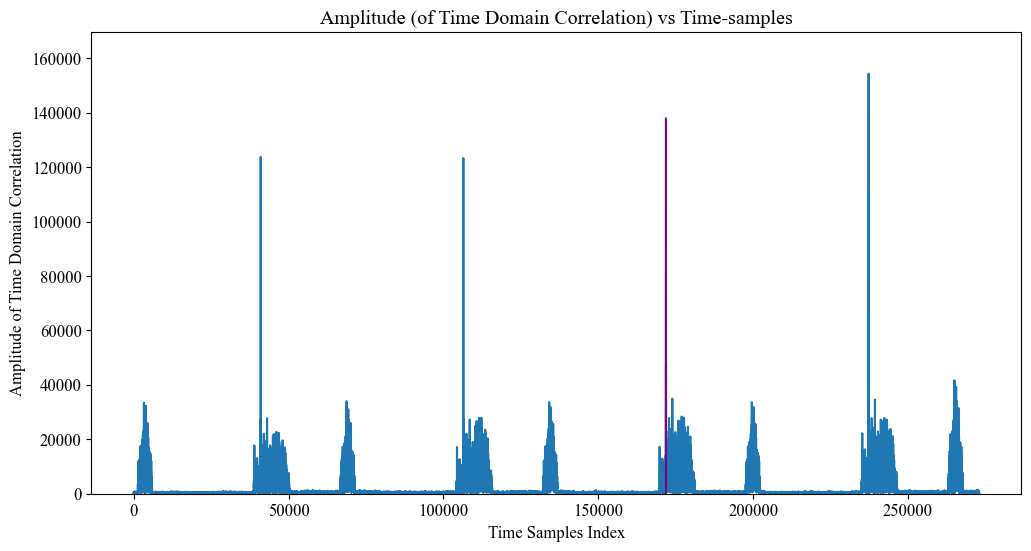

In [8]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1],
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")

pssDetection   = PSSDetection("largestPeak")
# ssboffset      = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 70*12
ssboffset          = int(numofGuardCarriers[0] + offsetToPointA)
# ssboffset      = None
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)

if(pssPeakIndices > rx_samples.size - 28*(fftSize + lengthCP[1])):
    pssPeakIndices = pssPeakIndices - 28*(fftSize + lengthCP[1])
        
## PSS Detection Plot
#################################################################
scaleFig = 2.5
fig, ax  = plt.subplots(figsize=(30/scaleFig, 15/scaleFig))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

In [9]:
pssPeakIndices

171826

## 8.2 CFO Estimation

In [10]:
## Parameters for computing CFO
cyclic_prefix_length      = lengthCP[1]                                     #Length of cyclic prefix
numSamples                = fftSize + cyclic_prefix_length                  #OFDM samples of 1 symbol
firstIndex                = pssPeakIndices                                  #PSS detection
pssOfdmSymbols            = rx_samples[firstIndex: firstIndex + numSamples] #PSS samples
 
obj                       = CarrierFrequencyOffsetEstimation(fftSize,cyclic_prefix_length)
cfoEst                    = obj(pssOfdmSymbols,numCFOIteration = 2)    ## Estimated CFO

## 8.2 OFDM Demodulation and SSB Extraction

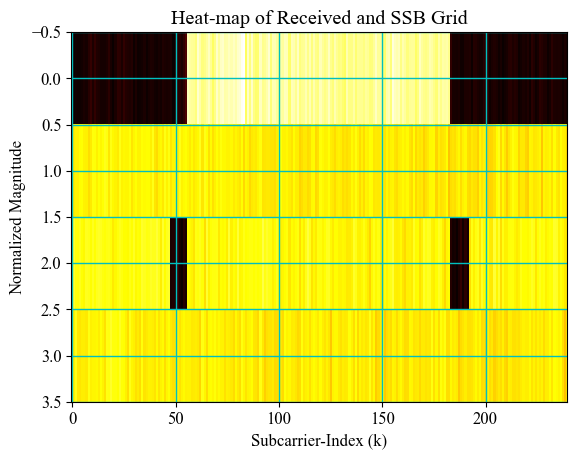

In [11]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices
# pssStartIndex   = pssPeakIndices[0][0]
 
# With CFO correction
cfo             = cfoEst

indices         = np.arange(rx_samples.size)
rxGrid          = ofdmDemodulator(((np.exp(-1j*cfo*indices/fftSize)*rx_samples).reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])
# rxGrid          = ofdmDemodulator((rx_samples.reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])

ssbSCSoffset   = ssboffset
ssbEstimate    = rxGrid[:,:,ssbSCSoffset:(ssbSCSoffset+240)]

# Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received and SSB Grid")
plt.show()


## 8.2 Spectrum: Received Grid

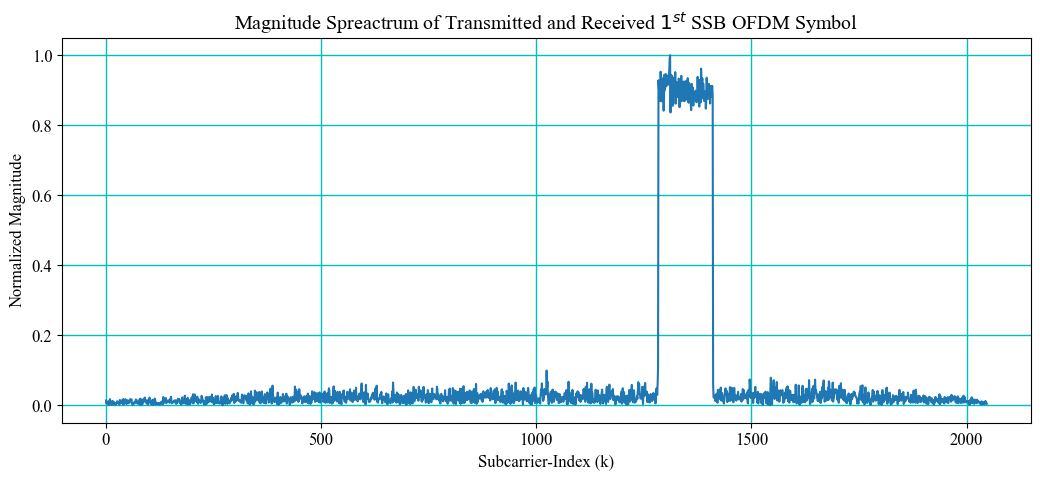

In [12]:
# Plot SSB
fig, ax = plt.subplots(figsize=(12.5, 5))
ax.plot(np.abs(rxGrid[0][0])/np.abs(rxGrid[0][0]).max())
# ax.plot(np.abs(X[2])/np.abs(X[2]).max())
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Magnitude Spreactrum of Transmitted and Received $1^{st}$ SSB OFDM Symbol")
plt.show()

## 8.2 Parameter Estimation for SSB and PBCH

In [13]:
nssbCandidatesInHrf = 4
dmrsLen             = 144
## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", nID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices

## Generate DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen)

In [14]:
int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit

(47, 0, 4, 0)

## 8.2 Channel Estimation and PBCH Symbol Equalization

In [15]:
# ## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
# ## Object for Channel Estimation
# chanEst        = ChannelEstimationAndEqualization(estimatorType = "ZF", interpolatorType = "NN")
# rxPBCHIndices  = rxSSBobject.pbchIndices
# pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rxDMRSIndices, rxPBCHIndices, 10)

chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile=True)
pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rN_ID)

## 8.2 PBCH Decoding and Constellation

C:\Users\asnat\Downloads\May4\May4\toolkit5G\ChannelCoder\PolarCoder\polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


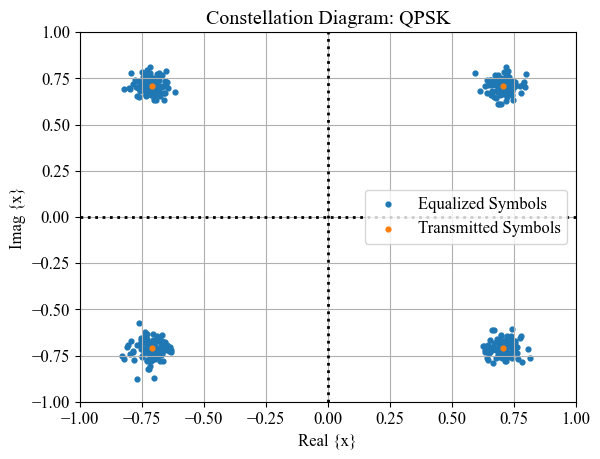

In [16]:
pbchSymbols    = np.array([1+1j,1-1j,-1-1j,-1+1j])/np.sqrt(2)
## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "maxlog"
# extractMIBinfo = False
extractMIBinfo = True
# carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
pbchDecoder    = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check   = pbchDecoder(pbchEstimate, 10, extractMIBinfo)


fig, ax = plt.subplots()
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate), s = 12, label = "Equalized Symbols")
ax.scatter(np.real(pbchSymbols), np.imag(pbchSymbols), s = 12, label = "Transmitted Symbols")
ax.grid()
ax.axhline(y=0, ls=":", c="k", lw = 2)
ax.axvline(x=0, ls=":", c="k", lw = 2)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.legend(loc = "best")
plt.show()

In [17]:
check

array([[ True]])

In [18]:
Neff

1272

In [19]:
firstSCIndex     = 388
ofdmDemodulator  = OFDMDemodulator(fftSize, lengthCP[1])
startSampleIndex = pssPeakIndices + 12*(fftSize + lengthCP[1])
# pssStartIndex   = pssPeakIndices[0][0]
rxResGrid        = ofdmDemodulator((np.exp(-1j*cfo*indices/fftSize)*rx_samples).reshape(1,-1)[...,startSampleIndex:(startSampleIndex+14*(fftSize+lengthCP[1]))])

rxGrid           = rxResGrid[0,:,firstSCIndex:firstSCIndex+Neff]

In [20]:
rxResGrid.shape

(1, 14, 2048)

In [21]:
rxGrid.shape

(14, 1272)

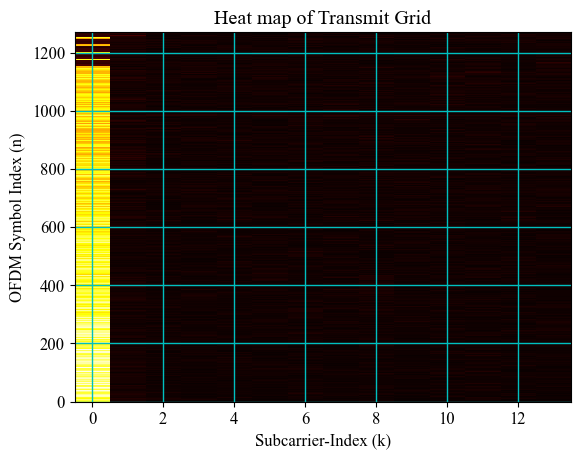

In [22]:
# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
ax.imshow(np.abs(rxGrid).T, cmap = 'hot', interpolation='nearest', aspect = "auto", origin = 'lower')
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 8.2 CORESET and Search Space Parameters

In [23]:
AggLevel = 16
monitoringSymbolsWithinSlot = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype = int)
startSymIndex               = np.nonzero(monitoringSymbolsWithinSlot)[0][0]

coresetID       = 1
cce_reg_Mapping = "interleaved" # CCE to REG mapping type
L               = 6             # REG-bundle size 
R               = 2             # Interleaver size 
nshift          = 0             # cyclic-shift index after interleaving

duration        = 1             # duration of CORESET 
frequencyDomainResources = np.array([1,1,1,1,1,1,1,1,1,
                                     1,1,1,1,1,1,1,1,1,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0], dtype = int) # 18 1's ==> 18*6 = 108 RBs

RNTI            = 0
N_ID            = rN_ID

coresetObj = CORESET(duration,frequencyDomainResources)
coresetPRBIndices = coresetObj(cce_REG_MappingType = cce_reg_Mapping, 
                               reg_BundleSize=L, interleaverSize = R, shiftIndex = nshift)
ssType                   = "USS"
coresetSize              = coresetObj.numCCESInCoreset       # CORESET size in number of CCEs
numCandidatesPerAL       = np.array([4,4,2,2,1], dtype=int)  # number of pdcch candidates per Aggregation Level.
ssObj = SearchSpaceSet(numerology = numerology, searchSpaceType = ssType, 
                       numCandidates = numCandidatesPerAL, coresetDuration = duration)

##############
# CCE indices
##############

M      = numCandidatesPerAL[int(np.log2(AggLevel))]    
ueCand = ssObj(AggLevel,RNTI,coresetSize,slotNumber,coresetID)  # PDCCH Candidates allocated


nBatches     = 1                   # number of batches 
numPDCCHSym  = int(54*AggLevel)    # number of REs occupied by PDCCH data (QPSK symbols)
numPDCCHdmrs = int(18*AggLevel)    # number of REs occupied by PDCCH DMRS symbols
E            = numPDCCHSym*2       # number of target Bits
K            = 20                # payload size in bits


In [24]:
ueCand

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]])

## 8.2 Channel Estimation and Equalization of PDCCH

In [25]:
rxPDCCHGrid = np.zeros((14,270*12), dtype = np.complex64)
(rxPDCCHGrid[:,0:Neff]) = rxGrid

##### Channel Estimation and Equalization #####

snr           = 10
channelEst    = ChannelEstimationAndEqualizationPDCCH(duration, frequencyDomainResources, monitoringSymbolsWithinSlot)
equalized_Sym = channelEst(rxPDCCHGrid[np.newaxis], cce_reg_Mapping, L, R, nshift,slotNumber, N_ID)
equalizedGrid = rxPDCCHGrid[np.newaxis]/channelEst.Hest

C:\Users\asnat\Downloads\May4\May4\toolkit5G\ReceiverAlgorithms\ChannelEstimation_and_Equalization\channelEstimationAndEqualizationPDCCH.py:195: RuntimeWarning: invalid value encountered in divide
  symbols[i]   = resourceGrid[i][self.pdcchIndices]/self.Hest[i][self.pdcchIndices]
C:\Users\asnat\AppData\Local\Temp\ipykernel_16800\3544564533.py:9: RuntimeWarning: invalid value encountered in divide
  equalizedGrid = rxPDCCHGrid[np.newaxis]/channelEst.Hest


## Blind Decoding

### Blind Decoding of PDCCH candidates
![PDCCH Blind Decoding](images/pdcch_blind_decoding.svg)

In [26]:
#########################
# Intiate Blind Decoding 
#########################

bdObj  = PDCCHCandidateBlindDecoding(coresetPRBIndices, duration, startSymIndex, ssType, AggLevel ,ueCand)
rdciBits = bdObj(equalizedGrid, K, E, snr, RNTI,N_ID, decoderType="SC", demappingMethod="app")
print("##########################################################################")
print()

------------------------------------------------------------------------------------------
Checking the CRC:
 [[ True]]
Blind Decoding Successful for the CCE Indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]..!
##########################################################################



### 8.2 Received Constellation

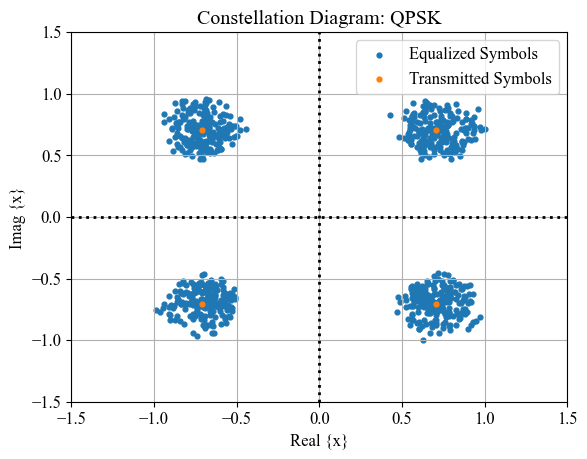

In [27]:
qpskSym = np.array([1+1j,1-1j,-1-1j,-1+1j])/np.sqrt(2)


fig, ax = plt.subplots()
ax.scatter(np.real(bdObj.equalizedDataSym), np.imag(bdObj.equalizedDataSym), s = 12, label = "Equalized Symbols")
ax.scatter(np.real(qpskSym), np.imag(qpskSym), s = 12, label = "Transmitted Symbols")
ax.grid()
ax.axhline(y=0, ls=":", c="k", lw = 2)
ax.axvline(x=0, ls=":", c="k", lw = 2)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.legend(loc = "best")
plt.show()



## 8.2 Quasi-real-time simulation

In [28]:
# function that draws each frame of the animation
qpskSymbols    = np.array([1+1j,1-1j,-1-1j,-1+1j])/np.sqrt(2)

def animate(i):
    # Receive samples
    rx_samples = sdr.rx()

    pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  nID2=None, freqOffset = ssboffset)

    if(pssPeakIndices < 3*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices + 14*(fftSize + lengthCP[1])
    elif(pssPeakIndices > rx_samples.size - 13*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices - 14*(fftSize + lengthCP[1])

    # # CFO estimation
    # obj    = CarrierFrequencyOffsetEstimation(fftSize,lengthCP[1])
    # cfoEst = obj(rx_samples[pssPeakIndices: pssPeakIndices + numSamples],numCFOIteration = 2)  # Computed CFO

    ## OFDM Demodulator Object
    ofdmDemodulator  = OFDMDemodulator(fftSize, lengthCP[1])
    startSampleIndex = pssPeakIndices - 2*(fftSize + lengthCP[1])
    # pssStartIndex   = pssPeakIndices[0][0]
    rxResGrid        =  ofdmDemodulator((np.exp(-1j*cfo*indices/fftSize)*rx_samples).reshape(1,-1)[...,startSampleIndex:(startSampleIndex+14*(fftSize+lengthCP[1]))])
    rxGrid           = rxResGrid[0,:,firstSCIndex:firstSCIndex+Neff]
    
    rxPDCCHGrid = np.zeros((14,270*12), dtype = np.complex64)
    rxPDCCHGrid[:,0:Neff] = rxGrid
    
    ##### Channel Estimation and Equalization #####
    snr           = 10
    channelEst    = ChannelEstimationAndEqualizationPDCCH(duration, frequencyDomainResources, monitoringSymbolsWithinSlot)
    equalized_Sym = channelEst(rxPDCCHGrid[np.newaxis], cce_reg_Mapping, L, R, nshift,slotNumber, N_ID)
    equalizedGrid = rxPDCCHGrid[np.newaxis]/channelEst.Hest
    
    
    ## Blind Decoding
    bdObj  = PDCCHCandidateBlindDecoding(coresetPRBIndices, duration, startSymIndex, ssType, AggLevel ,ueCand, False)
    rdciBits = bdObj(equalizedGrid, K, E, snr, RNTI,N_ID, decoderType="SC", demappingMethod="app")

    ax.clear()
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.scatter(np.real(bdObj.equalizedDataSym), np.imag(bdObj.equalizedDataSym), s = 12, label = "Equalized Symbols")
    ax.scatter(np.real(qpskSymbols), np.imag(qpskSymbols), s = 12, label = "Transmitted Symbols")
    ax.grid()
    ax.axhline(y=0, ls=":", c="k")
    ax.axvline(x=0, ls=":", c="k")
    ax.set_xlabel("Real {x}")
    ax.set_ylabel("Imag {x}")
    ax.set_title("Constellation Diagram: QPSK")

# Plot SSB
fig, ax = plt.subplots()
ax.set_aspect(True)

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim = animation.FuncAnimation(fig, animate, frames=1000, interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
plt.show()

anim.save("PDCCH_Constellation_CFO_Corrected.gif", fps = 10)

# writervideo = animation.FFMpegWriter(fps=60)
# anim.save('Overall.mp4', writer=writervideo)

![PDCCH_Constellation_CFO_Corrected](PDCCH_Constellation_CFO_Corrected.gif)